In [1]:
import logging
import ast
from itertools import product
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.algorithms.search_algorithm import AlgMetrics
from large_gcs.graph.graph import Graph, Vertex, Edge
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.algorithms.search_algorithm import ReexploreLevel
from large_gcs.algorithms.gcs_astar import GcsAstar
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_under,
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.cost_estimators.factored_collision_free_ce import FactoredCollisionFreeCE

from large_gcs.contact.contact_regions_set import ContactRegionParams

import numpy as np
from copy import deepcopy
from IPython.display import HTML


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
logging.getLogger("large_gcs").setLevel(logging.INFO)
logging.getLogger("drake").setLevel(logging.WARNING)

# Test target region

In [16]:
base_name = "cg_simple_3"

In [18]:
cg = ContactGraph.load_from_file(
    ContactGraphGeneratorParams.graph_file_path_from_name(base_name)
)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 44.43it/s]
INFO:large_gcs.graph.contact_graph:Loading 11 contact pair modes for 2 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 427.49it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 7543.71it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 9532.51it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 72/72 [00:00<00:00, 6715.51it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 72/72 [00:00<00:00, 4956.91it/s]
INFO:large_gcs.graph.graph:Adding 72 edges to graph...
100%|██████████| 72/72 [00:00<00:00, 4584.70it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 16), n_vertices=13, n_edges=72, sou

In [19]:
cost_estimator_se = ShortcutEdgeCE(
    cg, contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar_se = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator_se,
    reexplore_level=ReexploreLevel.NONE,
)
sol_se = gcs_astar_se.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.154, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 2 neighbors (0)
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 3, n_edges_visited: 1, n_vertices_explored: 2, vertex_coverage: 0.231, edge_coverage: 0.0139, time_wall_clock: 0.0208, n_gcs_solves: 2, gcs_solve_time_total: 0.00147, gcs_solve_time_iter_mean: 0.000733, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0.000162, gcs_solve_time_iter_min: 0.00057, gcs_solve_time_iter_max: 

In [17]:
cost_estimator = FactoredCollisionFreeCE(cg, use_combined_gcs=True, obj_multiplier=100)

gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 52.03it/s]
INFO:large_gcs.graph.contact_graph:Loading 11 contact pair modes for 2 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...


100%|██████████| 11/11 [00:00<00:00, 430.04it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 5981.35it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 7872.65it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 72/72 [00:00<00:00, 9221.35it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 72/72 [00:00<00:00, 3379.25it/s]
INFO:large_gcs.graph.graph:Adding 72 edges to graph...
100%|██████████| 72/72 [00:00<00:00, 3919.96it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 16), n_vertices=13, n_edges=72, source=[array([0, 0]), array([-2, -2])], target='regions', workspace=array([[-3,  3],
       [-3,  3]]), default_costs_constraints=None)
INFO:large_gcs.graph.factored_collision_free_graph:Creating vertex costs for factored_collision_free_graph...
100%|██████████| 2/2 [00:00<00:00, 9565.12

RuntimeError: Transition vertex 36925 has 0 outgoing edges, but 1 targets were specified. They need to be equal.

In [20]:
cg_inc = IncrementalContactGraph.load_from_file(
    ContactGraphGeneratorParams.inc_graph_file_path_from_name(base_name),
    should_incl_simul_mode_switches = True,
)

cost_estimator_se = ShortcutEdgeCE(
    cg_inc, contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar_se = GcsAstarConvexRestriction(
    cg_inc,
    cost_estimator=cost_estimator_se,
    reexplore_level=ReexploreLevel.NONE,
)
sol_se = gcs_astar_se.run()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 29330.80it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 13595.80it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 28.15it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (55)
100%|██████████| 55/55 [00:00<00:00, 8884.87it/s]
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.667, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_

In [15]:
cg_inc = IncrementalContactGraph.load_from_file(
    ContactGraphGeneratorParams.inc_graph_file_path_from_name(base_name),
    should_incl_simul_mode_switches = True,
)

cost_estimator = FactoredCollisionFreeCE(cg_inc, use_combined_gcs=True, obj_multiplier=100)

gcs_astar = GcsAstarConvexRestriction(
    cg_inc,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 36954.22it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9510.89it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 63.15it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 25909.86it/s]
INFO:large_gcs.graph.factored_collision_free_graph:Creating vertex costs for factored_collision_free_graph...
100%|██████████| 6/6 [00:00<00:00, 7092.96it/s]
INFO:large_gcs.graph.graph:Adding 6 vertices to graph...
100%|██████████| 6/6 [00:00<00:00, 11199.74it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 15/15 [00:00<00:00, 20887.97it/s]
INFO:large_gcs.graph.contact_graph:24 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 24/

# Factored CFree CE full test

In [2]:
base_name = "cg_maze_a2"

In [8]:
cg = ContactGraph.load_from_file(
    ContactGraphGeneratorParams.graph_file_path_from_name(base_name)
)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 58.58it/s]
INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:00<00:00, 387.12it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 11493.33it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 11858.31it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 8820.22it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 4580.63it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 4117.98it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vert

In [4]:
cg_inc = IncrementalContactGraph.load_from_file(
    ContactGraphGeneratorParams.inc_graph_file_path_from_name(base_name),
    should_incl_simul_mode_switches = False,
)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 25653.24it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 13443.28it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 54.41it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (132)
100%|██████████| 132/132 [00:00<00:00, 14862.64it/s]


In [ ]:
cost_estimator = FactoredCollisionFreeCE(cg, use_combined_gcs=False, obj_multiplier=100)

gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

In [ ]:
cost_estimator = FactoredCollisionFreeCE(cg, use_combined_gcs=True, obj_multiplier=100)

gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

In [ ]:
cost_estimator = FactoredCollisionFreeCE(cg_inc, use_combined_gcs=False, obj_multiplier=100)

gcs_astar = GcsAstarConvexRestriction(
    cg_inc,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

In [6]:
cost_estimator = FactoredCollisionFreeCE(cg_inc, use_combined_gcs=True, obj_multiplier=100)

gcs_astar = GcsAstarConvexRestriction(
    cg_inc,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.cost_estimators.factored_collision_free_ce:creating 2 collision free graphs...
0it [00:00, ?it/s]INFO:large_gcs.graph.factored_collision_free_graph:Creating vertex costs for factored_collision_free_graph...
100%|██████████| 18/18 [00:00<00:00, 8740.16it/s]
INFO:large_gcs.graph.graph:Adding 18 vertices to graph...
100%|██████████| 18/18 [00:00<00:00, 12759.42it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 153/153 [00:00<00:00, 6669.25it/s]
INFO:large_gcs.graph.contact_graph:222 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 222/222 [00:00<00:00, 22377.69it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 222/222 [00:00<00:00, 10680.98it/s]
INFO:large_gcs.graph.graph:Adding 222 edges to graph...
100%|██████████| 222/222 [00:00<00:00, 10377.54it/s]
INFO:large_gcs.graph.factored_collision_free_graph:Created factored collision free graph for obj0: GraphParams

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpppmenzfh/temp.m4v


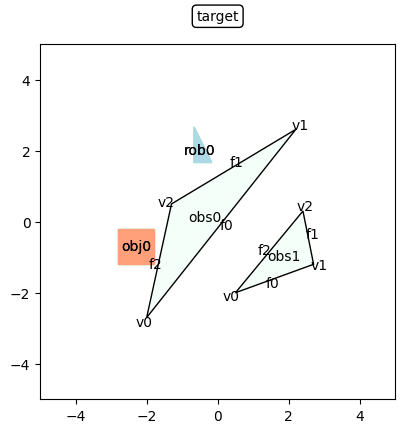

In [8]:
anim = cg_inc.animate_solution()
HTML(anim.to_html5_video())

# Shortcut Edge CE full test

In [2]:
base_name = "cg_trichal2"

In [10]:
cg = ContactGraph.load_from_file(
    ContactGraphGeneratorParams.graph_file_path_from_name(base_name)
)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 53.20it/s]
INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:00<00:00, 438.67it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 10694.18it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 12037.31it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 6817.75it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 5388.02it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 5090.84it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertices=181, n_edges=6120, source=[array([3.250, 0.000]), array([1.500, 0.500])], target

In [16]:
cg_inc = IncrementalContactGraph.load_from_file(
    ContactGraphGeneratorParams.inc_graph_file_path_from_name(base_name),
    should_add_gcs=True,
    # include_simultaneous_mode_swiches = False,
)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 13842.59it/s]


INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 12865.96it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 62.19it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 3759.14it/s]


In [5]:
cost_estimator_se = ShortcutEdgeCE(
    cg, contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar_se = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator_se,
    reexplore_level=ReexploreLevel.NONE,
)
sol_se = gcs_astar_se.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.011, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 1 neighbors (0)
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 3, n_edges_visited: 1, n_vertices_explored: 1, vertex_coverage: 0.0166, edge_coverage: 0.0002, time_wall_clock: 0.0131, n_gcs_solves: 1, gcs_solve_time_total: 0.000818, gcs_solve_time_iter_mean: 0.000818, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: 0.000818, gcs_solve_time_iter_max: 0.00

In [17]:
logging.getLogger("large_gcs.algorithms.gcs_astar_convex_restriction").setLevel(
    logging.INFO
)
cost_estimator_se = ShortcutEdgeCE(
    cg_inc, contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar_se = GcsAstarConvexRestriction(
    cg_inc,
    cost_estimator=cost_estimator_se,
    reexplore_level=ReexploreLevel.NONE,
)
sol_se = gcs_astar_se.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.667, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 1 neighbors (0)
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 3, n_edges_visited: 1, n_vertices_explored: 1, vertex_coverage: 0.0309, edge_coverage: 0.0204, time_wall_clock: 0.0119, n_gcs_solves: 1, gcs_solve_time_total: 0.000732, gcs_solve_time_iter_mean: 0.000732, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: 0.000732, gcs_solve_time_iter_max: 0.00

# Why does it say that some edges are infeasible when they are feasible in the standard contact graph? (Resolved)
The issue was in Shortcut Edge CE, when the neighbor was the target, the edge to the target wasn't getting properly removed, thus leading to solve convex restriction being called with multiple active edges to the target.

## Testing a short path

In [3]:
cg_inc = IncrementalContactGraph.load_from_file(
    ContactGraphGeneratorParams.inc_graph_file_path_from_name(base_name),
    should_add_gcs=True,
)
v_path = [
    "source",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f0-rob0_v1')",
]

active_edges = []
for i in range(len(v_path) - 1):
    active_edges.append((v_path[i], v_path[i + 1]))

for v in v_path[1:]:
    cg_inc.generate_neighbors(v)
    print(len(cg_inc.outgoing_edges(v)))

INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01


100%|██████████| 2/2 [00:00<00:00, 19553.86it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 7262.86it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 67.31it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 25169.58it/s]


48
62
35


In [4]:
# cg.set_target(v2)
# cg.solve_convex_restriction(active_edges)
cg_inc.set_target(v_path[-1])
cg_inc.solve_convex_restriction(active_edges)

ShortestPathSolution(is_success=True, cost=6.890873519933261, time=0.0014789537526667118, vertex_path=['source', "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f0-rob0_v1')"], ambient_path=[array([3.250, 0.000, 1.500, 0.500]), array([3.250, 3.250, 0.000, 0.000, 1.500, -1.333, 0.500, -2.167, -0.000,
       -0.000, -2.833, -2.667, -2.833, -2.667]), array([3.250, 3.250, -0.000, 0.000, -1.333, -1.333, -2.167, -2.167,
       -0.000, -0.000, -0.000, 0.000, -0.000, 0.000]), array([3.250, 3.250, 0.000, -0.000, -1.333, -1.333, -2.167, -2.167,
       -0.000, -0.000, -0.000, 0.000, -0.000, 0.000])], flows=[], result=<pydrake.solvers.MathematicalProgramResult object at 0x7f487f4cbd70>)

The above works, so that suggests to me that the problem lies somewhere in the shortcut CE...

In [5]:
cg_inc.set_target("target")
cg_inc.set_source("source")
cost_estimator_se = ShortcutEdgeCE(
    cg_inc, contact_shortcut_edge_cost_factory_over_obj_weighted
)
cost_estimator_se.set_alg_metrics(AlgMetrics())
subgraph = Graph()
for v in v_path[:-1]:
    subgraph.add_vertex(cg_inc.vertices[v], v)
for e in active_edges[:-1]:
    subgraph.add_edge(cg_inc.edges[e])
subgraph.add_vertex(cg_inc.vertices["target"], "target")
subgraph.set_source(v_path[0])
subgraph.set_target("target")
print(f"subgraph vertices: {subgraph.vertex_names}")
print(f"subgraph edges: {subgraph.edge_keys}")
edge_to_explore = cg_inc.edges[active_edges[-1]]
print(f"edge to explore: {edge_to_explore}")
cost_estimator_se.estimate_cost(
    subgraph, edge=edge_to_explore, solve_convex_restriction=True
)

subgraph vertices: ['source', "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')", 'target']
subgraph edges: [('source', "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"), ("('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')")]
edge to explore: Edge(u="('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')", v="('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f0-rob0_v1')", costs=[<pydrake.solvers.LinearCost object at 0x7f48c0c8b070>], constraints=[<pydrake.solvers.LinearEqualityConstraint object at 0x7f48c0c8bb30>], gcs_edge=<pydrake.geometry.optimization.GraphOfConvexSets.Edge object at 0x7f48c0c8dbf0>)


ShortestPathSolution(is_success=True, cost=236.65075298505283, time=0.0019303318113088608, vertex_path=['source', "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f0-rob0_v1')", 'target'], ambient_path=[array([3.250, 0.000, 1.500, 0.500]), array([3.250, 3.250, 0.000, -0.000, 1.500, -1.333, 0.500, -2.167, -0.000,
       -0.000, -2.833, -2.667, -2.833, -2.667]), array([3.250, 3.250, -0.000, -0.000, -1.333, -1.999, -2.167, -1.644,
       -0.000, -0.000, -0.665, 0.522, -0.665, 0.522]), array([3.250, 3.250, -0.000, -0.000, -1.999, -2.607, -1.644, -1.167,
       -0.000, -0.000, -0.608, 0.478, -0.608, 0.478]), array([-1.500, 0.000, -3.000, 0.000])], flows=[], result=<pydrake.solvers.MathematicalProgramResult object at 0x7f48c0c5bb70>)

This also works, I wonder what the problem is...

In the full shortcut CE test, the standard contact graph has these edges vs the incremental contact graph. The issue is that the edges to the target are not being removed when the target is the neighbor.

In [ ]:
correct = [
    ("source", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"),
    (
        "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')",
        "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')",
    ),
    ("('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f0-rob0_v1')", "target"),
    (
        "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')",
        "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f0-rob0_v1')",
    ),
]
wrong = [
    ("source", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"),
    ("('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')", "target"),
    (
        "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')",
        "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')",
    ),
    ("('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f0-rob0_v1')", "target"),
    (
        "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')",
        "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f0-rob0_v1')",
    ),
]

## Testing the full solution path built up incrementally
Let me do a quick test, if I generate the neighbors all along the solution path, does solving it work and are all the neighbors correct?

In [6]:
cg_inc = IncrementalContactGraph.load_from_file(
    ContactGraphGeneratorParams.inc_graph_file_path_from_name(base_name),
    should_add_gcs=True,
)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 10143.42it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 7774.43it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 61.99it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 14893.12it/s]


In [7]:
v_path = [
    "source",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f0-rob0_v1')",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')",
    "('IC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')",
    "('IC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')",
    "('IC|obs0_f2-obj0_f1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f0-rob0_v1')",
    "('IC|obs0_f2-obj0_f1', 'NC|obs0_f2-rob0_v0', 'IC|obj0_v0-rob0_f0')",
    "('NC|obs0_f2-obj0_f1', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')",
    "target",
]
active_edges = []
for v in range(len(v_path) - 1):
    active_edges.append((v_path[v], v_path[v + 1]))

In [8]:
for v in v_path:
    if v != "source" and v != "target":
        cg_inc.generate_neighbors(v)

In [9]:
cg_inc.set_target(v_path[-1])
cg_inc.solve_convex_restriction(active_edges)

ShortestPathSolution(is_success=True, cost=24.512826012087707, time=0.0019541271030902863, vertex_path=['source', "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f0-rob0_v1')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('IC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('IC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('IC|obs0_f2-obj0_f1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f0-rob0_v1')", "('IC|obs0_f2-obj0_f1', 'NC|obs0_f2-rob0_v0', 'IC|obj0_v0-rob0_f0')", "('NC|obs0_f2-obj0_f1', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')", 'target'], ambient_path=[array([3.250, 0.000, 1.500, 0.500]), array([3.250, 3.250, 0.000, 0.000, 1.500, 2.417, 0.500, -1.167, -0.000,
       -0.000, 0.917, -1.667, 0.917, -1.667]), array([3.250, 3.250, 0.000, 0.000, 2.417, 3.917, -1.167, -1.167, -0.000,
       -0.000, 1.500, 0.000, 1.500, 0.000]), array([3.250, 1.000, 0.000,

# Why are different numbers of outgoing neighbors generated compared to the standard contact graph? (Resolved)
There were a couple of issues:
1. workspace constraints were being added to the contact pair modes when the base polyhedrons were being constructed
2. The filtering of the edges with no intersection was not being done for vertices that were already in the subgraph

In [ ]:
def are_all_graphs_edges_valid(g, verbose=False):
    no_intersections = []
    for u, v in g.edge_keys:
        if not g._check_intersection(
            (g.vertices[u].convex_set.base_set, g.vertices[v].convex_set.base_set)
        ):
            no_intersections.append((u, v))

    print(f"num invalid edges: {len(no_intersections)}/{len(g.edge_keys)}")
    if verbose:
        print(f"invalid edges: {np.array(no_intersections)}")


# are_all_graphs_edges_valid(cg)

In [ ]:
are_all_graphs_edges_valid(cg_inc, verbose=True)

In [ ]:
# First edge investigated
u = "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"
v = "('NC|obs0_f2-obj0_f1', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f2-rob0_f2')"
v_contact_pair_mode_ids = ast.literal_eval(v)

# for mode_id in v_contact_pair_mode_ids:
#     print(f"cg_inc: {len(cg_inc._contact_pair_modes[mode_id].base_constraint_formulas)}, cg: {len(cg._contact_pair_modes[mode_id].base_constraint_formulas)}")

cg_inc._generate_vertex_neighbor(u, v_contact_pair_mode_ids)
v_cg = cg._create_contact_set_from_contact_pair_mode_ids(v_contact_pair_mode_ids)
v_cg_inc = cg_inc._create_contact_set_from_contact_pair_mode_ids(
    v_contact_pair_mode_ids
)

print(cg._check_intersection((cg.vertices[u].convex_set.base_set, v_cg.base_set)))
print(
    cg._check_intersection(
        (cg.vertices[u].convex_set.base_set, cg.vertices[v].convex_set.base_set)
    )
)
print((u, v) in cg.edges)

# # # This is different
# print(len(v_cg.base_constraint_formulas))
# print(len(v_cg_inc.base_constraint_formulas))

In [ ]:
print(len(cg._contact_pair_modes))
print(len(cg_inc._contact_pair_modes))
mode_id = "NC|obs0_f0-obj0_v3"
# mode_id = 'NC|obj0_f2-rob0_f2'
print(len(cg._contact_pair_modes[mode_id].base_constraint_formulas))
print(len(cg_inc._contact_pair_modes[mode_id].base_constraint_formulas))

In [ ]:
cg.vertices[u].convex_set.base_set.ambient_dimension()

In [ ]:
np.allclose(
    cg_inc.vertices[u].convex_set.base_set.A(), cg.vertices[u].convex_set.base_set.A()
)

In [ ]:
def are_vertex_sets_the_same(u):
    return np.allclose(
        cg_inc.vertices[u].convex_set.base_set.A(),
        cg.vertices[u].convex_set.base_set.A(),
    ) and np.allclose(
        cg_inc.vertices[u].convex_set.base_set.A(),
        cg.vertices[u].convex_set.base_set.A(),
    )


# are_vertex_sets_the_same("('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')")
# are_vertex_sets_the_same("('NC|obs0_f0-obj0_v3', 'NC|obs0_f1-rob0_f2', 'NC|obj0_f2-rob0_f2')")
are_vertex_sets_the_same(
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f0-rob0_v1')"
)

In [ ]:
def print_dim_A_b(vertex_name):
    print(f"\ncomparing dimensions of {vertex_name}")
    print(f"shape of A cg: {cg.vertices[vertex_name].convex_set.base_set.A().shape}")
    print(
        f"shape of A cg_inc: {cg_inc.vertices[vertex_name].convex_set.base_set.A().shape}"
    )
    print(f"shape of b cg: {cg.vertices[vertex_name].convex_set.base_set.b().shape}")
    print(
        f"shape of b cg_inc: {cg_inc.vertices[vertex_name].convex_set.base_set.b().shape}"
    )


def print_dim_A_b_set(convex_set):
    print(f"\ncomparing base dimensions of {convex_set}")
    print(f"shape of A: {convex_set.base_set.A().shape}")
    print(f"shape of b: {convex_set.base_set.b().shape}")

In [ ]:
for v in cg_inc.vertex_names:
    if v == "source" or v == "target":
        continue
    print_dim_A_b(v)

In [ ]:
print_dim_A_b(v)

In [ ]:
cg_inc.vertices[u].convex_set.base_set.A()

In [ ]:
cg_inc.vertices[u].convex_set.plot_base_set()

In [ ]:
(u, v) in cg_inc.edges

In [ ]:
cg_inc._modes_w_possible_edge_to_target

In [ ]:
cost_estimator = FactoredCollisionFreeCE(cg, use_combined_gcs=True, obj_multiplier=100)

gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

In [ ]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

In [ ]:
v1 = "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"
v2 = "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')"
active_edges = [
    ("source", v1),
    (v1, v2),
]
# cg.set_target(v2)
# cg.solve_convex_restriction(active_edges)
cg_inc.set_target(v2)
cg_inc.solve_convex_restriction(active_edges)

In [ ]:
# First vertex investigated
# vertex_name = "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"
# Second vertex investigated
vertex_name = "('NC|obs0_f0-obj0_v3', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')"
cg_edges = set([e.v for e in cg.outgoing_edges(vertex_name)])
cg_inc_edges = set([e.v for e in cg_inc.outgoing_edges(vertex_name)])
only_in_cg = np.array(list(cg_edges - cg_inc_edges))
only_in_cg_inc = np.array(list(cg_inc_edges - cg_edges))
print(f"{only_in_cg.size} Only in cg: \n{only_in_cg}")
print(f"{only_in_cg_inc.size} Only in cg_inc: \n{only_in_cg_inc}")

only_in_cg = only_in_cg[only_in_cg != "source"]

# mode_ids = ast.literal_eval(vertex_name)
# mode_ids_for_each_body_pair = []
# for id in mode_ids:
#     mode_ids_for_each_body_pair.append(
#         [id] + cg_inc._adj_modes[id]
#     )
# set_ids = list(product(*mode_ids_for_each_body_pair))
# set_ids_str = [str(set_id) for set_id in set_ids]
# in_cg_not_in_set_ids = np.array(list(set(only_in_cg) - set(set_ids_str)))
# print(f"{in_cg_not_in_set_ids.size} In cg but not in set_ids: \n{in_cg_not_in_set_ids}")

# for set_id in only_in_cg:
#     mode_ids = ast.literal_eval(set_id)
#     print(f"Generating {set_id}...")
#     cg_inc._generate_vertex_neighbor(vertex_name, mode_ids)

# # Verify that extra edges in cg actually have intersection
# for v in only_in_cg:
#     assert cg._check_intersection((cg.vertices[vertex_name].convex_set.base_set, cg.vertices[v].convex_set.base_set))

# # Verify that these sets are not empty
# for v in only_in_cg_inc:
#     assert not cg.vertices[v].convex_set.set.IsEmpty()

# # Are these not generated because they aren't in the adjacent modes?
# u_mode_ids = ast.literal_eval(vertex_name)
# for set_id in only_in_cg:
#     if set_id == "source": continue
#     v_mode_ids = ast.literal_eval(set_id)
#     print()
#     for i in range(len(u_mode_ids)):
#         print(f"{v_mode_ids[i]} in adj_modes to {u_mode_ids[i]}: {v_mode_ids[i] in cg_inc._adj_modes[u_mode_ids[i]] + [u_mode_ids[i]]}")

In [ ]:
cost_estimator = FactoredCollisionFreeCE(
    cg_inc, use_combined_gcs=True, obj_multiplier=100
)

gcs_astar = GcsAstarConvexRestriction(
    cg_inc,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

In [ ]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

In [ ]:
# from itertools import product
# mode_ids_for_each_body_pair = [
#     ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'],
#     ['B1', 'B2', 'B3',],
#     ['C1', 'C2', 'C3', 'C4', 'C5', 'C6'],
# ]
# mode_ids = ('A1', 'B1', 'C1')
# set_ids = list(product(*mode_ids_for_each_body_pair))
# print(f"Generating {len(set_ids)-1}")
# for set_id in set_ids:
#     if set_id != mode_ids:
#         print(f"Generating {set_id}")
#     else:
#         print(f"SKIPPING {set_id}")